<a href="https://colab.research.google.com/github/mkoskinas/project-2-nlp/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
This module contains code for training and evaluating a BERT model for fake news detection on Twitter data.

The main steps involved are:
1. Data preprocessing: Loading and cleaning the Twitter dataset.
2. Data splitting: Dividing the dataset into train, validation, and test sets.
3. Model training: Training a BERT model for binary classification (fake vs. real news).
4. Model evaluation: Evaluating the trained model's performance on the test set.
5. Prediction: Making predictions on new text data using the trained model.

The module also includes helper functions for analyzing the dataset, visualising results,
and performing error analysis on misclassified examples.
"""

"\nThis module contains code for training and evaluating a BERT model for fake news detection on Twitter data.\n\nThe main steps involved are:\n1. Data preprocessing: Loading and cleaning the Twitter dataset.\n2. Data splitting: Dividing the dataset into train, validation, and test sets.\n3. Model training: Training a BERT model for binary classification (fake vs. real news).\n4. Model evaluation: Evaluating the trained model's performance on the test set.\n5. Prediction: Making predictions on new text data using the trained model.\n\nThe module also includes helper functions for analyzing the dataset, visualising results,\nand performing error analysis on misclassified examples.\n"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import numpy as np
import pickle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

In [3]:
## Read Data for the Twitter Fake News Challenge

data = pd.read_csv(
    "data/training_data_lowercase.csv",
    encoding="latin-1",
    delimiter="\t",
    names=["label", "tweet"],
    skiprows=1,
)
print(data.head())
print(data.shape)

   label                                              tweet
0      0  drunk bragging trump staffer started russian c...
1      0  sheriff david clarke becomes an internet joke ...
2      0  trump is so obsessed he even has obamaâs nam...
3      0  pope francis just called out donald trump duri...
4      0  racist alabama cops brutalize black boy while ...
(34151, 2)


In [4]:
# Sample a few tweets for inspection
sample_tweets = data["tweet"].sample(10)

# Print the length and full content of the sampled tweets
for tweet in sample_tweets:
    print(f"Length: {len(tweet)}, Content: {tweet}")

Length: 71, Content: white house: iaea report on iran nuclear deal is more than technicality
Length: 61, Content: merkel silent on fourth term despite glowing words from obama
Length: 55, Content: clamor for justice: yugoslav court leaves global legacy
Length: 77, Content: watch young teenage thugs as they rob female reporter filming #baltimoreriots
Length: 57, Content: trump on boeing's air force one contract: 'cancel order!'
Length: 59, Content: fcc chairman rejects trump suggestion on broadcast licenses
Length: 65, Content: kenya's parliament takes three-week break at opposition's request
Length: 69, Content: trump gets his a** handed to him by alec baldwin and tom hanks on snl
Length: 38, Content: this republican hates ted cruz so much
Length: 57, Content: cambodia's opposition party gives up hope of escaping ban


In [5]:
# Display class distribution
print("Class Distribution:")
print(data["label"].value_counts(normalize=True))

# Basic dataset info
print("\nDataset Info:")
print(data.info())

# Check unique values in label column
print("\nUnique Labels:")
print(data["label"].unique())

Class Distribution:
label
0    0.514509
1    0.485491
Name: proportion, dtype: float64

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34151 entries, 0 to 34150
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   34151 non-null  int64 
 1   tweet   34151 non-null  object
dtypes: int64(1), object(1)
memory usage: 533.7+ KB
None

Unique Labels:
[0 1]


In [6]:
# Divide the dataset into training, validation, and test dataset

# First split: Create a holdout test set (20% of data)
train_val_data, test_data = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data["label"]
)

# Second split: Create validation set from remaining data
train_data, val_data = train_test_split(
    train_val_data,
    test_size=0.2,  # 20% of remaining data (16% of original data)
    random_state=42,
    stratify=train_val_data["label"],
)

# Print split sizes
print(f"Total samples: {len(data)}")
print(f"Training samples: {len(train_data)} ({len(train_data)/len(data):.1%})")
print(f"Validation samples: {len(val_data)} ({len(val_data)/len(data):.1%})")
print(f"Test samples: {len(test_data)} ({len(test_data)/len(data):.1%})")

# Save splits separately to prevent data leakage
train_data.to_csv("data/train_data.csv", index=False)
val_data.to_csv("data/validation_data.csv", index=False)
test_data.to_csv("data/test_data.csv", index=False)

Total samples: 34151
Training samples: 21856 (64.0%)
Validation samples: 5464 (16.0%)
Test samples: 6831 (20.0%)


In [7]:
# Check for missing values in the 'tweet' column
num_missing_tweets = val_data["tweet"].isnull().sum()

# Print the result
print(f"Number of missing tweets: {num_missing_tweets}")

Number of missing tweets: 0


In [8]:
# DATA PREPROCESSING

# HTML Content Analysis
def check_html_presence(data, text_column="tweet"):
    """
    Analyzes presence of HTML content in the dataset
    """
    # Initialise counters
    html_stats = {
        "total_tweets": len(data),
        "contains_html_tags": 0,
        "contains_scripts": 0,
        "contains_styles": 0,
        "contains_comments": 0,
    }

    # Sample tweets with HTML for inspection
    html_examples = []

    for text in data[text_column]:
        # Check for HTML tags
        if re.search(r"<[^>]+>", str(text)):
            html_stats["contains_html_tags"] += 1

            # Check for specific elements
            if re.search(r"<script[^>]*>", str(text)):
                html_stats["contains_scripts"] += 1
            if re.search(r"<style[^>]*>", str(text)):
                html_stats["contains_styles"] += 1
            if re.search(r"<!--", str(text)):
                html_stats["contains_comments"] += 1

            # Store example if it's one of first 5 found
            if len(html_examples) < 5:
                html_examples.append(text)

    # Calculate percentages
    for key in [
        "contains_html_tags",
        "contains_scripts",
        "contains_styles",
        "contains_comments",
    ]:
        percentage = (html_stats[key] / html_stats["total_tweets"]) * 100
        html_stats[f"{key}_percentage"] = f"{percentage:.2f}%"

    return {"stats": html_stats, "examples": html_examples}


# Run the analysis
html_analysis = check_html_presence(data)

# Print results
print("HTML Content Analysis:")
print("-" * 50)
print(f"Total tweets analyzed: {html_analysis['stats']['total_tweets']}")
print(
    f"Tweets containing HTML tags: {html_analysis['stats']['contains_html_tags']} ({html_analysis['stats']['contains_html_tags_percentage']})"
)
print(
    f"Tweets containing scripts: {html_analysis['stats']['contains_scripts']} ({html_analysis['stats']['contains_scripts_percentage']})"
)
print(
    f"Tweets containing styles: {html_analysis['stats']['contains_styles']} ({html_analysis['stats']['contains_styles_percentage']})"
)
print(
    f"Tweets containing comments: {html_analysis['stats']['contains_comments']} ({html_analysis['stats']['contains_comments_percentage']})"
)

if html_analysis["examples"]:
    print("\nExample tweets containing HTML:")
    for i, example in enumerate(html_analysis["examples"], 1):
        print(f"\nExample {i}:")
        print(example[:200] + "..." if len(example) > 200 else example)
else:
    print("\nNo HTML content found in tweets")

HTML Content Analysis:
--------------------------------------------------
Total tweets analyzed: 34151
Tweets containing HTML tags: 0 (0.00%)
Tweets containing scripts: 0 (0.00%)
Tweets containing styles: 0 (0.00%)
Tweets containing comments: 0 (0.00%)

No HTML content found in tweets


In [9]:
# Tweet Elements Analysis
def analyze_tweet_elements(data, text_column="tweet"):
    """
    Analyzes presence of Twitter-specific elements in the dataset
    """
    stats = {
        "total_tweets": len(data),
        "contains_mentions": 0,
        "contains_hashtags": 0,
        "contains_urls": 0,
        "contains_rt": 0,
        "contains_emojis": 0,
        "contains_numbers": 0,
    }

    # Store examples for each element
    examples = {k: [] for k in stats.keys() if k != "total_tweets"}

    for text in data[text_column]:
        text = str(text)  # Ensure text is string

        # Check for mentions (@)
        if re.search(r"@\w+", text):
            stats["contains_mentions"] += 1
            if len(examples["contains_mentions"]) < 3:
                examples["contains_mentions"].append(text)

        # Check for hashtags (#)
        if re.search(r"#\w+", text):
            stats["contains_hashtags"] += 1
            if len(examples["contains_hashtags"]) < 3:
                examples["contains_hashtags"].append(text)

        # Check for URLs
        if re.search(r"http\S+|www\S+|https\S+", text):
            stats["contains_urls"] += 1
            if len(examples["contains_urls"]) < 3:
                examples["contains_urls"].append(text)

        # Check for retweets
        if re.search(r"rt @\w+:", text, re.IGNORECASE):
            stats["contains_rt"] += 1
            if len(examples["contains_rt"]) < 3:
                examples["contains_rt"].append(text)

        # Check for emojis (basic check)
        if re.search(r"[^\w\s.,!?\'\"@]", text):
            stats["contains_emojis"] += 1
            if len(examples["contains_emojis"]) < 3:
                examples["contains_emojis"].append(text)

        # Check for numbers
        if re.search(r"\d+", text):
            stats["contains_numbers"] += 1
            if len(examples["contains_numbers"]) < 3:
                examples["contains_numbers"].append(text)

    # Calculate percentages - Iterate over a copy of keys or use list comprehension
    # This avoids modifying the dictionary during iteration
    for key in list(stats.keys()):
        if key != "total_tweets":
            percentage = (stats[key] / stats["total_tweets"]) * 100
            stats[f"{key}_percentage"] = f"{percentage:.2f}%"

    return {"stats": stats, "examples": examples}


# Run the analysis
tweet_analysis = analyze_tweet_elements(data)

# Print results
print("Tweet Elements Analysis:")
print("-" * 50)
print(f"Total tweets analyzed: {tweet_analysis['stats']['total_tweets']}")
for key in tweet_analysis["stats"].keys():
    if key != "total_tweets" and not key.endswith("_percentage"):
        print(
            f"\n{key.replace('_', ' ').title()}: {tweet_analysis['stats'][key]} ({tweet_analysis['stats'][key + '_percentage']})"
        )
        if tweet_analysis["examples"][key]:
            print("Examples:")
            for i, example in enumerate(tweet_analysis["examples"][key], 1):
                print(f"{i}. {example}")

Tweet Elements Analysis:
--------------------------------------------------
Total tweets analyzed: 34151

Contains Mentions: 6 (0.02%)
Examples:
1. christian âprophetâ literally loses his @ss when he takes on wild lions for jesus
2. @ammon_bundyâs ridiculous late night twitter rant has everyone talking (tweets)
3. american workers scr@wed over by outsourcing jobs get their day in court

Contains Hashtags: 253 (0.74%)
Examples:
1. protesters welcome trump home to his golden tower with the best #resistance display yet (image)
2. #trumpchicken is now trending and these tweets are hilarious (images)
3. #bringbackobama hashtag blows up on twitter as americans share memories (tweets)

Contains Urls: 7 (0.02%)
Examples:
1. https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/
2. https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/
3. https://100percentfedup.com

In [10]:
# Perform the necessary cleaning based on the above analyses

def clean_tweet(text):
    """
    Optimised cleaning function that:
    - Removes emojis and special characters
    - Preserves numbers (for fact checking)
    - Preserves basic punctuation
    - Handles hashtags
    """
    text = str(text)

    # Remove emojis and special characters but keep numbers and basic punctuation
    text = re.sub(r"[^a-zA-Z0-9\s.,!?\'\"@]", " ", text)

    # Handle hashtags
    text = re.sub(r"#(\w+)", r"\1", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text)

    return text.strip()


# Test the function with examples from the dataset
test_cases = [
    "sheriff david clarke becomes an internet joke for threatening to poke people âin the eyeâ",
    "cnn calls it: a democrat will represent alabama in the senate for the first time in 25 years",
    "john mccain wanted another 74 twitter followers",
]

print("Testing cleaning function:")
for i, test in enumerate(test_cases, 1):
    print(f"\nTest {i}:")
    print("Original:", test)
    print("Cleaned:", clean_tweet(test))

# Apply cleaning to each split separately
train_data["cleaned_tweet"] = train_data["tweet"].apply(clean_tweet)
val_data["cleaned_tweet"] = val_data["tweet"].apply(clean_tweet)
test_data["cleaned_tweet"] = test_data["tweet"].apply(clean_tweet)

# 4. Print some statistics for verification
print("Dataset Split Sizes:")
print("-" * 50)
print(f"Training samples: {len(train_data)} ({len(train_data)/len(data):.1%})")
print(f"Validation samples: {len(val_data)} ({len(val_data)/len(data):.1%})")
print(f"Test samples: {len(test_data)} ({len(test_data)/len(data):.1%})")

# 5. Show examples from training set
print("\nTraining Set Cleaning Examples:")
print("-" * 50)
for i, (orig, cleaned) in enumerate(
    zip(train_data["tweet"].head(), train_data["cleaned_tweet"].head()), 1
):
    print(f"\nExample {i}:")
    print(f"Original: {orig}")
    print(f"Cleaned:  {cleaned}")

# Select only the desired columns before saving to CSV
train_data = train_data[["label", "cleaned_tweet"]]  # Select for train_data
val_data = val_data[["label", "cleaned_tweet"]]  # Select for val_data
test_data = test_data[["label", "cleaned_tweet"]]  # Select for test_data

# 3. Save the cleaned splits
train_data.to_csv("data/cleaned_train_data.csv", index=False)
val_data.to_csv("data/cleaned_validation_data.csv", index=False)
test_data.to_csv("data/cleaned_test_data.csv", index=False)

Testing cleaning function:

Test 1:
Original: sheriff david clarke becomes an internet joke for threatening to poke people âin the eyeâ
Cleaned: sheriff david clarke becomes an internet joke for threatening to poke people in the eye

Test 2:
Original: cnn calls it: a democrat will represent alabama in the senate for the first time in 25 years
Cleaned: cnn calls it a democrat will represent alabama in the senate for the first time in 25 years

Test 3:
Original: john mccain wanted another 74 twitter followers
Cleaned: john mccain wanted another 74 twitter followers
Dataset Split Sizes:
--------------------------------------------------
Training samples: 21856 (64.0%)
Validation samples: 5464 (16.0%)
Test samples: 6831 (20.0%)

Training Set Cleaning Examples:
--------------------------------------------------

Example 1:
Original: bombshell report: nsa offered to give hillaryâs emails to fbiâjames comey rejected them
Cleaned:  bombshell report nsa offered to give hillary s emails to f

In [11]:
# Train a model to classify the tweets

# Load pre-cleaned data
train_data = pd.read_csv("data/cleaned_train_data.csv")
val_data = pd.read_csv("data/cleaned_validation_data.csv")

# Initialise tokenizer and encode data
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Encode training data
train_encodings = tokenizer(
    train_data["cleaned_tweet"].tolist(),
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="tf",
)

# Encode validation data
val_encodings = tokenizer(
    val_data["cleaned_tweet"].tolist(),
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="tf",
)

# Convert labels to numpy arrays
train_labels = train_data["label"].values
val_labels = val_data["label"].values

# Create and compile model
model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=1, hidden_dropout_prob=0.15
)

# Compile model with warmup
total_steps = (len(train_data) // 16) * 3
warmup_steps = total_steps // 10

optimizer = tf.keras.optimizers.Adam(
    tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=2e-5, first_decay_steps=warmup_steps
    )
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

model.summary()
"""
# Train the model
print("Starting training...")

# Convert BatchEncoding to dictionaries before passing to model.fit
history = model.fit(
    {key: val for key, val in train_encodings.items()},
    train_labels,
    validation_data=({key: val for key, val in val_encodings.items()}, val_labels),
    epochs=3,
    batch_size=16,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,  # Increased patience
            restore_best_weights=True,
            min_delta=0.0005
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.2,
            patience=2,
            min_delta=0.0005,
            min_lr=5e-6
        )
    ]
)

# Save the model, tokenizer, and history
# Save BERT model
model.save_weights('bert_model_weights.h5')

# Save training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

"""

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


'\n# Train the model\nprint("Starting training...")\n\n# Convert BatchEncoding to dictionaries before passing to model.fit\nhistory = model.fit(\n    {key: val for key, val in train_encodings.items()},\n    train_labels,\n    validation_data=({key: val for key, val in val_encodings.items()}, val_labels),\n    epochs=3,\n    batch_size=16,\n    callbacks=[\n        tf.keras.callbacks.EarlyStopping(\n            monitor=\'val_accuracy\',\n            patience=3,  # Increased patience\n            restore_best_weights=True,\n            min_delta=0.0005\n        ),\n        tf.keras.callbacks.ReduceLROnPlateau(\n            monitor=\'val_accuracy\',\n            factor=0.2,\n            patience=2,\n            min_delta=0.0005,\n            min_lr=5e-6\n        )\n    ]\n)\n\n# Save the model, tokenizer, and history\n# Save BERT model\nmodel.save_weights(\'bert_model_weights.h5\')\n\n# Save training history\nwith open(\'training_history.pkl\', \'wb\') as f:\n    pickle.dump(history.histo

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


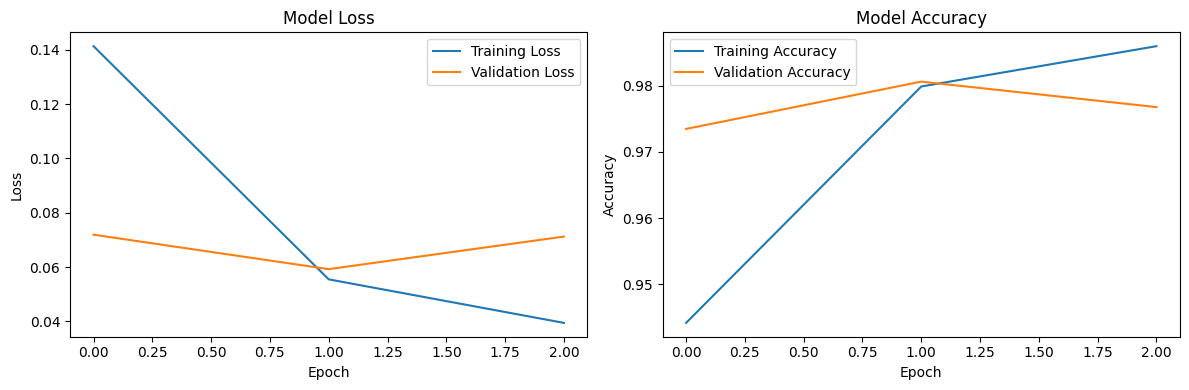


Testing predictions:
1/1 [==============================] - 6s 6s/step

Text: Breaking: Scientists discover miracle cure for all diseases!
Prediction: REAL
Probability of being fake: 0.10%
1/1 [==============================] - 0s 39ms/step

Text: New study shows correlation between exercise and health benefits
Prediction: FAKE
Probability of being fake: 73.77%


In [13]:
# Load the model
loaded_model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=1, hidden_dropout_prob=0.15
)
# Get tokeniser directly from BERT
loaded_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Compile loaded model
loaded_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Load the trained weights
loaded_model.load_weights("data/bert_model_weights.h5")

# Load history if it exists
try:
    with open("data/training_history.pkl", "rb") as f:
        loaded_history = pickle.load(f)
except:
    loaded_history = None
    print("No history file found")

# Plot the training history if it exists
if loaded_history:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(loaded_history["loss"], label="Training Loss")
    plt.plot(loaded_history["val_loss"], label="Validation Loss")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loaded_history["accuracy"], label="Training Accuracy")
    plt.plot(loaded_history["val_accuracy"], label="Validation Accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Function for making predictions
def predict_fake_news(text):
    """
    Predicts whether a given text is fake news or not using a pre-trained model.

    Args:
        text (str): The input text to be classified as fake or real news.

    Returns:
        dict: A dictionary containing the following keys:
            - 'text' (str): The input text.
            - 'probability_fake' (float): The probability that the text is fake news (between 0 and 1).
            - 'prediction' (str): The predicted label, either 'FAKE' or 'REAL'.
    """
    # Preprocess
    processed_text = clean_tweet(text)

    # Encode
    inputs = loaded_tokenizer(
        processed_text,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="tf",
    )

    # Predict
    predictions = loaded_model.predict(inputs)
    probability = tf.sigmoid(predictions.logits).numpy()[0][0]

    return {
        "text": text,
        "probability_fake": float(probability),
        "prediction": "FAKE" if probability > 0.5 else "REAL",
    }


# Test the model
sample_texts = [
    "Breaking: Scientists discover miracle cure for all diseases!",
    "New study shows correlation between exercise and health benefits",
]

print("\nTesting predictions:")
for text in sample_texts:
    result = predict_fake_news(text)
    print(f"\nText: {result['text']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Probability of being fake: {result['probability_fake']:.2%}")

214/214 [==============================] - 26s 111ms/step

Model Accuracy:
--------------------------------------------------
Accuracy: 0.9814 (98.14%)

Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.98      3515
        Real       0.98      0.98      0.98      3316

    accuracy                           0.98      6831
   macro avg       0.98      0.98      0.98      6831
weighted avg       0.98      0.98      0.98      6831



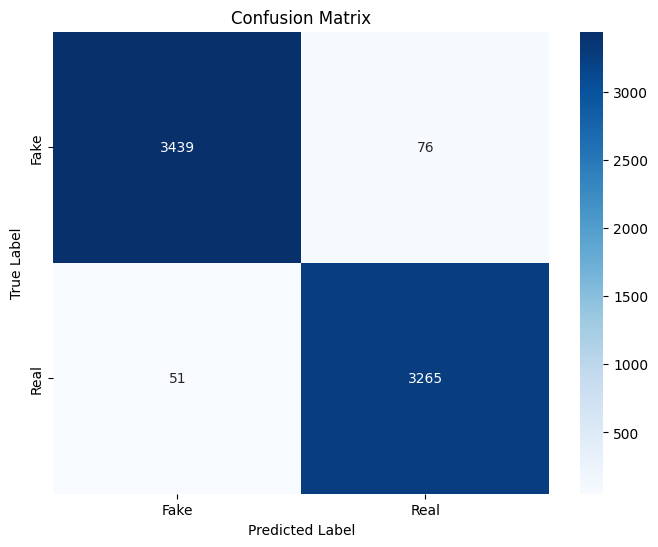

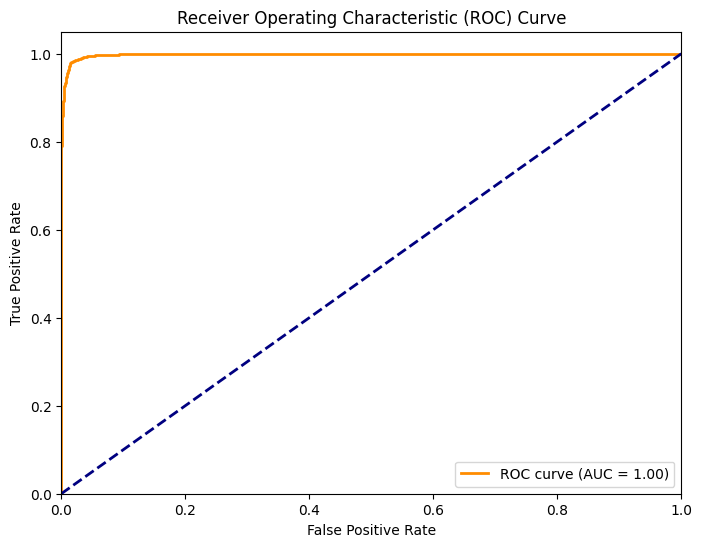


Sample of Misclassified Texts:
--------------------------------------------------

Text: ivanka trump becomes unpaid white house employee...
True Label: Real
Predicted: Fake (confidence: 0.11)

Text: victims of terrorist attack question lack of presidential support...
True Label: Fake
Predicted: Real (confidence: 0.97)

Text: to beat zika in rio who prescribes safe sex and avoiding poor areas...
True Label: Real
Predicted: Fake (confidence: 0.33)

Text: clinton lawless protocol chief sold seats to obama white house state dinners...
True Label: Fake
Predicted: Real (confidence: 0.87)

Text: u.s. mosque linked to terrorist group received 2.7 million in federal funding...
True Label: Fake
Predicted: Real (confidence: 0.98)


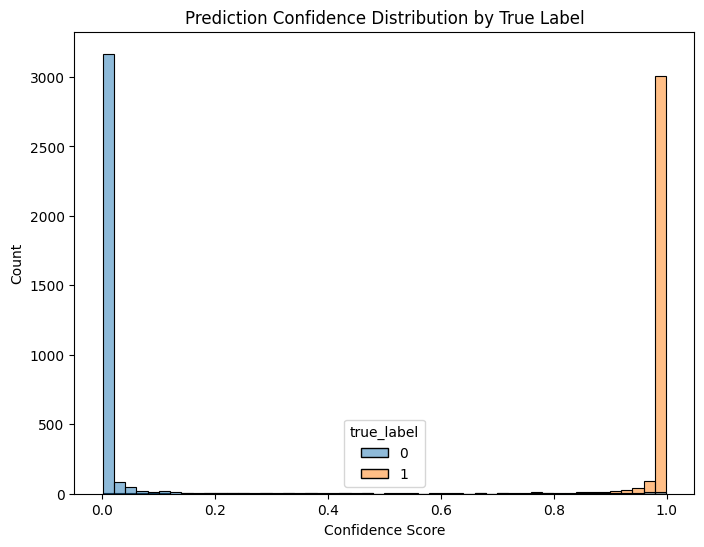


Sample Predictions:
--------------------------------------------------
1/1 [==============================] - 0s 34ms/step

Text: Breaking: Scientists discover miracle cure for all diseases!
Prediction: Fake
Confidence: 99.90%
Probability of being real news: 0.10%
1/1 [==============================] - 0s 36ms/step

Text: New study shows correlation between exercise and health benefits
Prediction: Real
Confidence: 73.77%
Probability of being real news: 73.77%
1/1 [==============================] - 0s 37ms/step

Text: Local community organizes cleanup event at city park
Prediction: Fake
Confidence: 68.58%
Probability of being real news: 31.42%


In [14]:
def evaluate_bert_model(
    loaded_model, loaded_tokenizer, test_data, class_names=["Fake", "Real"]
):
    """
    Comprehensive evaluation of the BERT model
    """
    # Get predictions
    test_encodings = loaded_tokenizer(
        test_data["cleaned_tweet"].tolist(),
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="tf",
    )

    predictions = loaded_model.predict(
        {key: val for key, val in test_encodings.items()}
    )
    y_pred_proba = tf.sigmoid(predictions.logits).numpy().flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    y_true = test_data["label"].values

    # Print Accuracy first
    accuracy = (y_pred == y_true).mean()
    print("\nModel Accuracy:")
    print("-" * 50)
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Classification Report
    print("\nClassification Report:")
    print("-" * 50)
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Error Analysis
    errors = pd.DataFrame(
        {
            "text": test_data["cleaned_tweet"],
            "true_label": y_true,
            "predicted_label": y_pred,
            "confidence": y_pred_proba,
        }
    )

    # Filter misclassifications
    misclassified = errors[errors["true_label"] != errors["predicted_label"]]

    print("\nSample of Misclassified Texts:")
    print("-" * 50)
    for _, row in misclassified.head().iterrows():
        print(f"\nText: {row['text'][:100]}...")
        print(f"True Label: {class_names[row['true_label']]}")
        print(
            f"Predicted: {class_names[row['predicted_label']]} (confidence: {row['confidence']:.2f})"
        )

    # Performance Metrics by Confidence
    plt.figure(figsize=(8, 6))
    sns.histplot(data=errors, x="confidence", hue="true_label", bins=50, alpha=0.5)
    plt.title("Prediction Confidence Distribution by True Label")
    plt.xlabel("Confidence Score")
    plt.ylabel("Count")
    plt.show()

    return {"confusion_matrix": cm, "roc_auc": roc_auc, "misclassified": misclassified}


# Run evaluation with loaded model and tokenizer
evaluation_results = evaluate_bert_model(loaded_model, loaded_tokenizer, test_data)


# For predictions, update the function call to use loaded model/tokenizer
def predict_fake_news(text, class_names=["Fake", "Real"]):
    """
    Predicts whether a given text is fake news or real news using a pre-trained BERT model.

    Args:
        text (str): The input text to be classified as fake or real news.
        class_names (list, optional): A list containing the class names for the binary classification task.
            Default is ["Fake", "Real"].

    Returns:
        dict: A dictionary containing the following keys:
            - 'text' (str): The input text.
            - 'probability_real' (float): The probability that the text is real news (between 0 and 1).
            - 'prediction' (str): The predicted label, either the first or second element of `class_names`.
            - 'confidence' (float): The confidence score of the prediction (maximum of probability and 1 - probability).
    """
    processed_text = clean_tweet(text)
    inputs = loaded_tokenizer(
        processed_text,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="tf",
    )

    predictions = loaded_model.predict(inputs)
    probability = tf.sigmoid(predictions.logits).numpy()[0][0]

    return {
        "text": text,
        "probability_real": float(probability),
        "prediction": class_names[1] if probability > 0.5 else class_names[0],
        "confidence": max(probability, 1 - probability),
    }


# Test with sample texts
sample_texts = [
    "Breaking: Scientists discover miracle cure for all diseases!",
    "New study shows correlation between exercise and health benefits",
    "Local community organizes cleanup event at city park",
]

print("\nSample Predictions:")
print("-" * 50)
for text in sample_texts:
    result = predict_fake_news(text)
    print(f"\nText: {result['text']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"Probability of being real news: {result['probability_real']:.2%}")

In [ ]:
"""import pandas as pd

# Load the new dataset without labels
new_data = pd.read_csv("path/to/new_dataset.csv", names=["tweet"])

# Create an empty column for labels
new_data["label"] = 0

# Function to make predictions and fill in labels
def predict_and_label(row):
    text = row["tweet"]
    prediction = predict_fake_news(text)
    label = 0 if prediction["prediction"] == "Fake" else 1
    return label

# Apply the prediction function to each row
new_data["label"] = new_data.apply(predict_and_label, axis=1)

# Save the labeled dataset
new_data.to_csv("path/to/labeled_dataset.csv", index=False)
"""